# Classical Graph Neural Network (GNN) 

Classifying Pythia8 Quark and Gluon Jets Using a Graph Convolutional Network (GCN) and Graph Convolutional Attention Network (GCAT)

Author: Roy T. Forestano

Date: 15-29 June 2023

Based on formalisms from:
- Graph Convolutional Networks: https://tkipf.github.io/graph-convolutional-networks/
- Neural Message Passing for Quantum Chemistry: https://arxiv.org/abs/1704.01212
- E(n) Equivariant Graph Neural Networks: https://arxiv.org/abs/2102.09844

$\bf\text{Database Information: Pythia8 Quark and Gluon Jets for Energy Flow}$

Two datasets of quark and gluon jets generated with Pythia 8, one with all kinematically realizable quark jets and one that excludes charm and bottom quark jets (at the level of the hard process). The one without c and b jets was originally used in Energy Flow Networks: Deep Sets for Particle Jets. Generation parameters are listed below:

Pythia 8.226 (without bc jets), Pythia 8.235 (with bc jets), s√=14TeV
Quarks from WeakBosonAndParton:qg2gmZq, gluons from WeakBosonAndParton:qqbar2gmZg with the Z decaying to neutrinos
FastJet 3.3.0, anti-ki jets with R=0.4
pjetT∈[500,550]GeV,|yjet|<1.7
There are 20 files in each dataset, each in compressed NumPy format. Files including charm and bottom jets have 'withbc' in their filename. There are two arrays in each file

X: (100000,M,4), exactly 50k quark and 50k gluon jets, randomly sorted, where M is the max multiplicity of the jets in that file (other jets have been padded with zero-particles), and the features of each particle are its pt, rapidity, azimuthal angle, and pdgid.


y: (100000,), an array of labels for the jets where gluon is 0 and quark is 1.

[1] P. T. Komiske, E. M. Metodiev, J. Thaler, Energy Flow Networks: Deep Sets for Particle Jets, JHEP 01 (2019) 121, arXiv:1810.05165.

[2] Petar Veliˇckovi ́c, Guillem Cucurull, Arantxa Casanova, Adriana Romero, Pietro Lio and Yoshua Bengio. Graph attention networks. 2018

Other References:

1. Multiplicity of Jets: https://link.springer.com/article/10.1134/S1063778818110236
2. GAT: https://github.com/Diego999/pyGAT

## Preprocess Data

1. We will utlize a package called particle in order to find the particle masses based on their pdgid's.
2. We will take the given features $p_T,y,\phi$ to create new physically realizable features including the 

$\bf\text{Transverse Mass Per Multiplicity ($m_{T,ij}$)}$
$$m_{T,ij} = \sqrt{m_{ij}^2 + p_{T,ij}^2}$$
$\bf\text{Energy Per Multiplicity ($E_{ij}$)}$
$$E_{ij} = m_{T,ij} \text{cosh} y_{ij}$$
$\bf\text{Energy Per Jet ($E_i$)}$
$$E_i = \sum_j E_{ij}$$
$\bf\text{Kinematic Momenta Components Per Multiplicity ($\vec{p}_{ij} = (p_{x,ij},p_{y,ij},p_{z,ij})$)} \equiv (N,M,3)$ 
$$p_{x,ij} = p_{T,ij} \text{cos} \phi$$
$$p_{y,ij} = p_{T,ij} \text{sin} \phi$$
$$p_{z,ij} = m_{T,ij} \text{sinh} y_{ij}$$
$\bf\text{Kinematic Momenta Components Per Jet ($\vec{p}_{i} = (p_{x,i},p_{y,i},p_{z,i})$)} \equiv (N,3)$ 
$$\vec{p}_{i} = \sum_j \vec{p}_{ij}$$
$\bf\text{Transverse Momenta Per Jet ($p_{T,i} = |(p_{x,i},p_{y,i})|$)} \equiv (N,1)$ 
$$\vec{p}_{i} = \sqrt{ \sum_{x,y}\left(\sum_j \vec{p}_{ij} \right)^2}$$
$\bf\text{Mass Per Jet ($m_{i}$)} \equiv (N,1)$ 
$$m_{i} = \sqrt{ (E_i - \vec{p}_{i} \cdot \vec{p}_{i} )^2}$$
$\bf\text{Rapidity Per Jet ($y_{i}$)} \equiv (N,1)$ 
$$y_{i} =\frac{1}{2}\ln \left( \frac{E_i + p_{z,i}}{E_i - p_{z,i}} \right)$$
2. Make Edges: Connect three nearest neighbors via invariant mass between particles 

$$m_{ij} = \left( E_{i} - E_{j} \right)^2 - \left( \vec{p}_{i} - \vec{p}_{j} \right)^2$$

Add connections for EQNN (as location data) via $R = \sqrt{\Delta \phi^2 + \Delta y^2}$

$$m_{ij} = \sqrt{ \left( \phi_{i} - \phi_{j} \right)^2 + \left( y_{i} - y_{j} \right)^2 }$$

Add masses, energy, and three momentum components to node features.

In [1]:
# !pip install particle
# !pip install torch_geometric
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-1.13.0+cpu.html

In [2]:
import numpy as np
from numpy.random import default_rng
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time
import os
import copy
from particle import Particle
from sklearn.model_selection import train_test_split
from gnn_egnn.preprocess import *

import torch
from torch import nn as nn
#from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, InMemoryDataset, download_url
# from torch_geometric.nn import GCNConv
# from torch_geometric.nn import GATConv
# from torch_geometric.nn import Sequential
# from torch_geometric import nn
# from torch_geometric.nn import global_mean_pool


torch.set_default_dtype(torch.float64)
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Device: ',device)

np.random.seed(0)
torch.manual_seed(0)

Device:  cuda


In [3]:
path = 'Data_wo_bc/pythia8/'

In [4]:
# files = []
# for i in range(20):
#     if i<10:
#         files.append(np.load(path+f'QG_jets_0{i}.npz', allow_pickle=True))
#     else:
#         files.append(np.load(path+f'QG_jets_{str(i)[0]+str(i)[1]}.npz', allow_pickle=True))

In [5]:
# len(files)

In [6]:
# M=np.zeros(len(files),)
# for i,file in enumerate(files):
#     lst = file.files
#     for j,item in enumerate(lst):
#         if j==0:
#             M[i] = file[item][0,:,0].shape[0]

In [7]:
# max_multiplicity = int(M.max())

In [8]:
# #names = []
# #data = []
# for i,file in enumerate(files):
#     lst = file.files
#     print(f'File: {i}')
#     for j,item in enumerate(lst):
#         #names.append(item)
#         #data.append(file[item])
#         if j==0:
#             if i==0:
#                 x_data = np.pad(array=file[item],pad_width=((0,0),(0,int(max_multiplicity-file[item].shape[1])),(0,0)), mode='constant', constant_values=((None,None),(None,0.),(None,None)))
#                 print('X Data Shape: ', x_data.shape)
#             else:
#                 x_new = np.pad(array=file[item],pad_width=((0,0),(0,int(max_multiplicity-file[item].shape[1])),(0,0)), mode='constant', constant_values=((None,None),(None,0.),(None,None)))
#                 print('X Data Shape: ', x_new.shape)
#                 x_data = np.vstack([x_data,x_new])
#         elif j==1:
#             if i==0:
#                 y_data = file[item]
#                 print('Y Data Shape: ', y_data.shape)
#             else:
#                 y_data = np.vstack([y_data,file[item]])
#                 print('Y Data Shape: ', y_data.shape)
#             #names.append(item)
#             #print(files[item].shape)#.item()['0'].shape)
#             #data.append(files[item])

In [9]:
# np.save(path+'appended_data.npy',x_data)

In [10]:
# np.save(path+'appended_labels.npy',y_data)

In [11]:
x_data = np.load(path+'appended_data.npy')
y_data = np.load(path+'appended_labels.npy').reshape(x_data.shape[0],)

In [12]:
x_data[:,:,:].shape

(2000000, 148, 4)

In [13]:
y_data.shape

(2000000,)

In [14]:
#x = data[0]; y = data[1]

In [15]:
Ntry = 1000

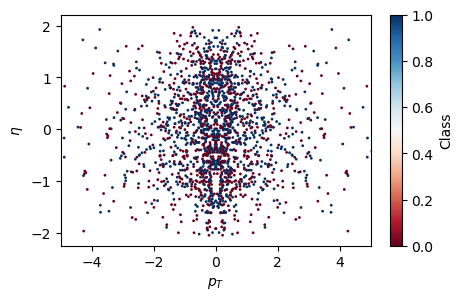

In [16]:
plt.figure(figsize=(5,3))
plt.scatter(x_data[:Ntry,0,0],x_data[:Ntry,0,1],s=1,c=y_data[:Ntry],cmap='RdBu')#,vmin=0.,vmax=1.)
plt.scatter(-x_data[:Ntry,0,0],x_data[:Ntry,0,1],s=1,c=y_data[:Ntry],cmap='RdBu')#,vmin=0.,vmax=1.)
plt.xlabel('$p_T$')
plt.ylabel('$\eta$')
plt.xlim(-5,5)
plt.title('')
plt.colorbar(label='Class')

In [17]:
unique_particles = np.unique(x_data[:Ntry,:,3])

In [18]:
unique_particles

array([-2212., -2112.,  -321.,  -211.,   -13.,   -11.,     0.,    11.,
          13.,    22.,   130.,   211.,   321.,  2112.,  2212.])

In [19]:
for i,particle in enumerate(unique_particles):
    if particle!=0:
        symbol =Particle.from_pdgid(particle).name
        mass = Particle.from_pdgid(particle).mass/1000
        print(i,particle,symbol,mass)

0 -2212.0 p~ 0.93827208816
1 -2112.0 n~ 0.9395654204999999
2 -321.0 K- 0.49367700000000003
3 -211.0 pi- 0.13957039000000002
4 -13.0 mu+ 0.1056583755
5 -11.0 e+ 0.0005109989499999999
7 11.0 e- 0.0005109989499999999
8 13.0 mu- 0.1056583755
9 22.0 gamma 0.0
10 130.0 K(L)0 0.49761099999999997
11 211.0 pi+ 0.13957039000000002
12 321.0 K+ 0.49367700000000003
13 2112.0 n 0.9395654204999999
14 2212.0 p 0.93827208816


In [20]:
#np.save('masses.npy',masses)

In [21]:
# masses = torch.tensor(np.load('masses.npy'))

In [22]:
print('--- Finding All Unique Particles ---')
unique_particles = np.unique(x_data[:Ntry,:,3])
print()
print('--- Inserting Masses ---')
masses = np.zeros((x_data[:Ntry].shape[0],x_data[:Ntry].shape[1]))
for i,particle in tqdm(enumerate(unique_particles)):
    if particle!=0:
        mass = Particle.from_pdgid(particle).mass/1000
        inds = np.where(particle==x_data[:Ntry,:,3])
        masses[inds]=mass # GeV
print()
print('--- Calculating Momenta and Energies ---')
#theta = torch.arctan(torch.exp(-X[:,:,1]))*2 # polar angle
pt        = x_data[:Ntry,:,0]     # transverse momentum
rapidity  = x_data[:Ntry,:,1]     # rapidity
phi       = x_data[:Ntry,:,2]     # azimuthal angle

mt        = np.sqrt(pt**2+masses**2) # Transverse mass
energy    = mt*np.cosh(rapidity) # Energy per multiplicity bin
e_per_jet = energy.sum(axis=1)  # total energy per jet summed across multiplicity bins

px = pt*np.cos(phi)  # momentum in x
py = pt*np.sin(phi)  # momentum in y
pz = mt*np.sinh(rapidity)  # momentum in z

# three momentum
p = np.stack(( px[:,:,None],  
               py[:,:,None],
               pz[:,:,None]), axis=2 )

p_per_jet        = np.sum(p,axis=1)  # total componet momentum per jet
#pt_per_Mbin      = np.sqrt(np.sum(p_per_jet[:,:2]**2, axis=1))  # transverse momentum per jet
#mass_per_jet     = np.sqrt(e_per_jet**2-np.sum(p_per_jet**2,axis=1)) # mass per jet
#rapidity_per_jet = np.log( (e_per_jet+p_per_jet[:,2])/(e_per_jet-p_per_jet[:,2]) )/2  # rapidity per jet from analytical formula
#end_multiplicity_indx_per_jet = np.sum(pt!=0,axis=1).int() # see where the jet (graph) ends

--- Finding All Unique Particles ---

--- Inserting Masses ---


15it [00:00, 1660.98it/s]


--- Calculating Momenta and Energies ---


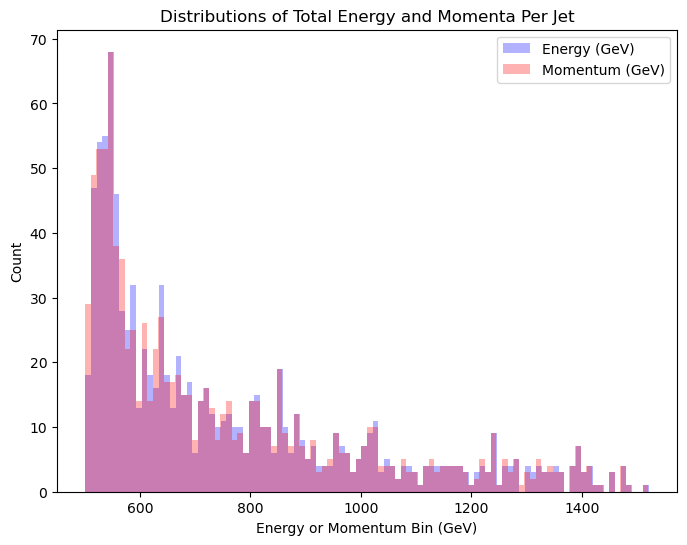

In [23]:
plt.figure(figsize=(8,6))
plt.hist(e_per_jet, color='b', alpha=0.3, bins=100, label='Energy (GeV)')
plt.hist(np.sqrt(np.sum((p_per_jet)**2,axis=1)), color='r', alpha=0.3, bins=100,label='Momentum (GeV)')
plt.title('Distributions of Total Energy and Momenta Per Jet')
plt.xlabel('Energy or Momentum Bin (GeV)')
plt.ylabel('Count')
plt.legend()
plt.show()

## Preprocess data

In [24]:
N=200000
rng = default_rng(seed=0)
indices = rng.choice(x_data.shape[0], size=N, replace=False)
nodes_per_graph = 20
# x_data_proc, y_data_proc, edge_tensor, edge_indx_tensor, edge_attr_matrix, graph_help = preprocess_general(x_data[indices],y_data[indices]) #,masses[:N])
x_data_proc, y_data_proc, edge_tensor, edge_indx_tensor, edge_attr_matrix, graph_help = preprocess_fixed_nodes(x_data[indices],y_data[indices],nodes_per_graph = nodes_per_graph) #,masses[:N])
N = x_data_proc.shape[0]

--- Finding All Unique Particles ---

--- Inserting Masses ---


15it [00:00, 24.25it/s]



--- Calculating Momenta and Energies ---

--- Calculating Edge Tensors ---


100%|██████████| 200000/200000 [02:43<00:00, 1223.96it/s]


In [25]:
# Check to see if we have the same number of types of particles per jet
#unique_ptypes_per_jet = [ np.unique(x[i,:,3]).shape[0] for i in range(x.shape[0]) ]

In [26]:
# l=0
# max_val = 0
# for i in range(np.where(x[l,:,1]==0)[0][0]):
#     for j in range(np.where(x[l,:,1]==0)[0][0]):
#         val=np.sqrt((x[l,i,1:3]-x[l,j,1:3])**2).sum(axis=0)
#         if val>max_val:
#             max_val = val

In [27]:
# max_val

In [28]:
# d_matrix = np.zeros((x[:,0,3].shape[0],x[0,:,3].shape[0],x[0,:,3].shape[0]))
# for l in tqdm(range(x[:,0,3].shape[0])):
#     for i in range(x[l,:,3].shape[0]):
#         inds_edge = np.where(x[l,i,3]==x[l,:,3])
#         d_matrix[l,i,inds_edge] = np.sqrt((x[l,i,1:3]-x[l,inds_edge,1:3])**2).sum(axis=0))
#     d_matrix[l,:,:]+=np.identity(x[0,:,3].shape[0])

In [29]:
#np.save('edge_matrix.npy',d_matrix)

In [30]:
#d_matrix = np.load('edge_matrix.npy')

In [31]:
#d_matrix.shape

In [32]:
# x.max(axis=1).max(axis=0).shape

In [33]:
# def process(feature_data,class_labels,feature_data_max=None):
#     # Normalize features
#     feature_data_max = feature_data.max(axis=1).max(axis=0)
#     feature_data = feature_data/feature_data_max[:]
#     feature_data = torch.tensor(feature_data)[:,:,:]
#     class_labels = torch.tensor(class_labels)[:]
#     return feature_data, class_labels

In [34]:
# x_data, y_data = process(x,y)

In [35]:
print('----- Check for the correctly sized tensors -----')
print()
print(f'Jet Data: {x_data_proc.shape}')
print(f'Classification: {y_data_proc.shape}')
print(f'Full Edge Information: {edge_tensor.shape}')
print(f'Edge Index Information: {edge_indx_tensor.shape}')
print(f'Edge Attribute Information: {edge_attr_matrix.shape}')
print(f'Graph Structure Information: {graph_help.shape}')
print('\n')
print('----- Check that each tensor is normalized -----')
print()
print(f'Jet Data max: {torch.max(x_data_proc)}')
print(f'Classification Max: {torch.max(y_data_proc)}')
print(f'Edge Length Max: {torch.max(edge_tensor)}')

----- Check for the correctly sized tensors -----

Jet Data: torch.Size([187827, 20, 8])
Classification: torch.Size([187827])
Full Edge Information: torch.Size([187827, 20, 20])
Edge Index Information: torch.Size([187827, 2, 380])
Edge Attribute Information: torch.Size([187827, 380, 1])
Graph Structure Information: torch.Size([187827, 4])


----- Check that each tensor is normalized -----

Jet Data max: 1.0
Classification Max: 1
Edge Length Max: 1.0


In [36]:
print('----- Check the structure of the dataset -----')
print()
print(f'Number of graphs (jets): {x_data_proc.shape[0]}')
print(r'Number of features per node (p_T(M),y,phi,m,E,px,py,pz): '+f'{x_data_proc.shape[2]}')
print(f'Number of classes (2: Quarks or Gluons): {np.unique(y_data_proc).shape[0]}')
print()
print('----- Check the structure of one graph -----')
print()
i=0
number_of_edges = graph_help[i,3]
# Gather some statistics about the first graph.
print(f'Number of nodes (particle IDs): {x_data_proc[i,:,0].shape[0]}')
print(f'Number of edges: {number_of_edges}')
print(f'Average node degree: {number_of_edges / x_data_proc[i,:,0].shape[0]:.2f}')
print(f'Is undirected: {True}')

----- Check the structure of the dataset -----

Number of graphs (jets): 187827
Number of features per node (p_T(M),y,phi,m,E,px,py,pz): 8
Number of classes (2: Quarks or Gluons): 2

----- Check the structure of one graph -----

Number of nodes (particle IDs): 20
Number of edges: 380.0
Average node degree: 19.00
Is undirected: True


In [37]:
# Create a dataset class
class Create_Dataset(Dataset):
    def __init__(self, edge_index, x, edge_attr, y, graph_info, transform=None):
        self.edge_index = edge_index
        self.x          = x
        self.edge_attr  = edge_attr
        self.y          = y
        self.graph_info = graph_info
        self.transform  = transform
    
    def __len__(self):
        return self.y.shape[0]
        
    # Could also just define an x,y,z then pass these variables
    # in the training functions over the loop for batch (actually think that way is easier to read)
    def __getitem__(self, index):
        sample = {'edge_index': self.edge_index[index,:,:self.graph_info[index,3]],
                'x': self.x[index,:int(self.graph_info[index,2]),:],
                'edge_attr': self.edge_attr[index,:self.graph_info[index,3]],
                'y': self.y[index] }

        if self.transform is not None:          
            sample = self.transform(sample)
        return sample

In [38]:
train_index   = int(N*0.7)
val_index    = int(N*0.9)
batch_size = 64
# Create Datasets for Torch for the training and testing pahses
dataset = []
for i in tqdm(range(N)):
#     dataset.append(Data(edge_index=edge_indx_tensor[i,:,:int(graph_help[i,3])],x=x_data_proc[i,:int(graph_help[i,2]),:],edge_attr=edge_attr_matrix[i,:int(graph_help[i,3])],y=y_data_proc[i]))
    dataset.append(Data(edge_index=edge_indx_tensor[i,:,:],
                        x=x_data_proc[i,:,:],
                        edge_attr=edge_attr_matrix[i,:],
                        y=y_data_proc[i]))

training_data = dataset[:train_index]
val_data      = dataset[train_index:val_index]
test_data     = dataset[val_index:]
# Create data loaders
train_dataloader = DataLoader(training_data, 
                              batch_size = batch_size,
                              shuffle = True, 
                              num_workers = 0)

val_dataloader  = DataLoader(val_data, 
                              batch_size = batch_size,
                              shuffle = False, 
                              num_workers = 0)

test_dataloader  = DataLoader(test_data, 
                              batch_size = batch_size,
                              shuffle = False, 
                              num_workers = 0)

print(f'Number of training graphs: {train_index}')
print(f'Number of validation graphs: {val_index-train_index}')
print(f'Number of test graphs: {N-val_index}')


# for step, data in enumerate(train_dataloader):
#     print(f'Step {step + 1}:')
#     print('=======')
#     print(f'Number of graphs in the current batch: {data.num_graphs}')
#     print(data)
#     print()

100%|██████████| 187827/187827 [00:05<00:00, 32668.83it/s]

Number of training graphs: 131478
Number of validation graphs: 37566
Number of test graphs: 18783


In [39]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Architecture 1: Graph Convolutional Network (GCN)

In [40]:
# class GCN(torch.nn.Module):
#     def __init__(self, hidden_channels,num_of_features,num_of_classes):
#         super(GCN, self).__init__()

#         self.gcnn = Sequential('x, edge_index, batch', #edge_attr, batch) 
#                                [ (nn.Dropout(p=0.2), 'x -> x'),
#                                 (GCNConv(in_channels=num_of_features, out_channels=hidden_channels), 'x, edge_index-> x1'),
#                                 nn.ReLU(inplace=True),
#                                 (GCNConv(in_channels=hidden_channels, out_channels=hidden_channels), 'x1, edge_index -> x2'),
#                                 nn.ReLU(inplace=True),
#                                 (GCNConv(in_channels=hidden_channels, out_channels=hidden_channels), 'x1, edge_index -> x2'),
#                                 (global_mean_pool, 'x2, batch -> x'),# Mean Pooling Layer to Latent Space
#                                ])
        
#         self.reduce = nn.Linear(in_features=hidden_channels, out_features=num_of_classes)
            
#     def forward(self, x, edge_index, batch): # data.edge_attr, data.batch) 
#         # Extract Node Embeddings
#         x = self.gcnn(x, edge_index, batch)  # data.edge_attr, data.batch) 
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = self.reduce(x)
#         return x

In [41]:
# def train_on_dataset(model,loss_fn,train_loader):
#     model.train()
#     for data in train_loader:  # Iterate in batches over the training dataset.
#         pred = model(data.x, data.edge_index, data.batch)# data.edge_attr, data.batch)   # Perform a single forward pass.
#         loss = loss_fn(pred, data.y)  # Compute the loss.
#         loss.backward()  # Derive gradients.
#         optimizer.step()  # Update parameters based on gradients.
#         optimizer.zero_grad()  # Clear gradients.
#     return loss
    

# def test_on_dataset(model,dataloader):
#     model.eval()
#     num_correct = 0
#     size = len(dataloader.dataset)
#     for data in dataloader:  # Iterate in batches over the training/test dataset.
#         out = model(data.x, data.edge_index, data.batch)# data.edge_attr, data.batch) 
#         loss = loss_fn(out, data.y)
#         pred = out.argmax(dim=1)  # Use the class with highest probability.
#         num_correct += (pred==data.y).sum().int()  # Check against true labels.
#     return loss, num_correct / size  # Derive ratio of correct predictions.

# def train(model,optimizer,loss_fn,train_dataloader,test_dataloader,epochs):
#     history = {'train_loss': [],'test_loss':[],'train_accuracy': [],'test_accuracy':[]} 
#     best_val_loss = torch.inf
#     best_val_acc = 0.
#     start = time()
#     for i in range(epochs):
#         loss = train_on_dataset(model,loss_fn,train_dataloader)
#         train_loss, train_acc = test_on_dataset(model,train_dataloader)
#         test_loss, test_acc = test_on_dataset(model,test_dataloader)

#         history['train_loss'].append(train_loss.data.item())
#         history['test_loss'].append(test_loss.data.item())
#         history['train_accuracy'].append(train_acc.data.item())
#         history['test_accuracy'].append(test_acc.data.item())
        
#         if best_val_acc<train_acc:
#         #if train_loss < best_val_loss:
#             best_val_acc = train_acc
#             best_val_loss = train_loss
#             best_model = copy.deepcopy(model)
#             best_model_wts = copy.deepcopy(model.state_dict())
            
# #         if i<9:
# #             print(f'Epoch {i+1}   |  Train Loss: {train_loss:>8f}  |  Train Acc: {train_acc:>4f} | Test Acc: {test_acc:.4f}')
# #         else:
# #             print(f'Epoch {i+1}  |  Train Loss: {train_loss:>8f}  |  Train Acc: {train_acc:>4f} | Test Acc: {test_acc:.4f}')
#         if i<9:
#             print(f'Epoch {i+1}   |  Train Loss: {train_loss:>4f} | Test Loss: {test_loss:.4f}  |  Train Acc: {train_acc:>4f} | Test Acc: {test_acc:.4f}')
#         else:
#             print(f'Epoch {i+1}  |  Train Loss: {train_loss:>4f} | Test Loss: {test_loss:.4f}  |  Train Acc: {train_acc:>4f} | Test Acc: {test_acc:.4f}')

#     end = time()
#     total_time = end-start
#     print(f"Time: {total_time:.5f} sec")  #|  Best Loss: {best_val_loss:.5f}")
#     print("Complete.")
#     return {'model': best_model,'history': history}

In [42]:
# torch.manual_seed(0)
# number_of_hidden_channels = batch_size
# num_of_features = x_data_proc.shape[2]
# num_of_classes  = np.unique(y_data_proc).shape[0]
# lr = 5e-3
# model = GCN(hidden_channels=number_of_hidden_channels,
#             num_of_features=num_of_features,
#             num_of_classes=num_of_classes)
# print(model)


# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# loss_fn = torch.nn.CrossEntropyLoss()
# epochs= 100
# training = train(model=model,
#                  optimizer=optimizer,
#                  loss_fn=loss_fn,
#                  train_dataloader=train_dataloader,
#                  test_dataloader=test_dataloader,
#                  epochs=epochs)

In [43]:
# # Plot the training accuracy
# fig = plt.figure(figsize=(8,5))
# plt.plot(training['history']['train_loss'],c='b',label='Train Loss')
# plt.plot(training['history']['test_loss'],c='g',label='Test Loss')
# plt.plot(training['history']['train_accuracy'],c='cyan',label='Train Loss')
# plt.plot(training['history']['test_accuracy'],c='darkorange',label='Test Loss')
# plt.title('Training History')
# plt.xlabel('Epoch')
# plt.ylabel('Loss/Accuracy')
# plt.legend()

In [44]:
# model = copy.deepcopy(training['model'])
# model.eval()
# num_correct = 0
# size = len(test_dataloader.dataset)
# # Compare to initialized test_data = y_data_proc[train_index:]
# test_predicitons = torch.zeros((size,1))
# for i,data in tqdm(enumerate(test_dataloader)):  # Iterate in batches over the training/test dataset.
#     out = model(data.x, data.edge_index, data.batch)  
#     pred = out.argmax(dim=1)  # Use the class with highest probability.
#     num_correct += (pred==data.y).sum().int()
#     if len(test_data)<(i+1)*batch_size:
#         test_predicitons[i*batch_size:] = pred.reshape((len(test_data)-i*batch_size,1))
#     else:
#         test_predicitons[i*batch_size:(i+1)*batch_size] = pred.reshape((batch_size,1))
# print('Accuracy for GCN: ',num_correct/size)

In [45]:
# print(train_index)
# print(len(test_data))

In [46]:
# from sklearn.metrics import confusion_matrix
# # Calculate the confusion matrix
# conf_matrix = confusion_matrix(y_true=y_data_proc[val_index:], y_pred=test_predicitons)
# # Print the confusion matrix using Matplotlib
# fig, ax = plt.subplots(figsize=(4, 3))
# im = ax.imshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
# for i in range(conf_matrix.shape[0]):
#     for j in range(conf_matrix.shape[1]):
#         ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
# plt.xlabel('Pred', fontsize=18)
# plt.ylabel('True', fontsize=18)
# plt.title('Confusion Matrix for GCN', fontsize=18)
# plt.xticks(ticks=[0,1],labels=['Gluon','Quark'])
# plt.yticks(ticks=[0,1],labels=['Gluon','Quark'])
# plt.colorbar(im)
# plt.show()

## Architecture 2: Graph Convolutional Attention Network (GCAT)

In [47]:
# class GAT(nn.Module):
#     def __init__(self, hidden_channels, number_of_features, number_of_classes, dropout1, dropout2, number_attention_heads):
#         super(GAT, self).__init__()
#         self.dropout1 = dropout1
#         self.dropout2 = dropout2
#         #self.in_att = Sequential('x, edge_index, batch',[(GATConv(in_channels = number_of_features, out_channels = hidden_channels, dropout2=dropout2, concat=True), 'x, edge_index -> x1')
#         self.attentions = [ Sequential('x, edge_index, edge_attr, batch',[(GATConv(in_channels = number_of_features, out_channels = hidden_channels, dropout2=dropout2, concat=True), 'x, edge_index, edge_attr -> x')]) for _ in range(number_attention_heads)]
#         for i, attention in enumerate(self.attentions):
#             self.add_module('attention_{}'.format(i), attention)
            
    
# #         self.out_att = Sequential('x, edge_index, batch',[(GATConv(in_channels = number_of_hidden_channels*number_attention_heads, out_channels = hidden_channels, dropout2=dropout2, concat=False), 'x, edge_index -> x1')])
#         self.out_att = Sequential('x, edge_index, edge_attr, batch',[(GATConv(in_channels = number_of_hidden_channels*number_attention_heads, out_channels = hidden_channels, dropout2=dropout2, concat=False), 'x, edge_index, edge_attr -> x')])

# #         self.pool = Sequential('x, edge_index, edge_attr, batch',      
# #                            [(global_mean_pool, 'x, batch -> x'),# Mean Pooling Layer to Latent Space
# #                            ]) 
#         self.gat = Sequential('x, edge_index, edge_attr, batch', 
#                                [(GATConv(in_channels = number_of_hidden_channels, out_channels = hidden_channels, dropout2=dropout2, concat=False), 'x, edge_index, edge_attr -> x1'),
#                                 nn.ReLU(inplace=True),
#                                 (GATConv(in_channels = number_of_hidden_channels, out_channels = hidden_channels, dropout2=dropout2, concat=False), 'x1, edge_index, edge_attr -> x2'),
#                                 nn.ReLU(inplace=True),
#                                 (GATConv(in_channels = number_of_hidden_channels, out_channels = hidden_channels, dropout2=dropout2, concat=False), 'x2, edge_index, edge_attr -> x3'),
#                                 nn.ReLU(inplace=True),
#                                 (GATConv(in_channels = number_of_hidden_channels, out_channels = hidden_channels, dropout2=dropout2, concat=False), 'x3, edge_index, edge_attr -> x4'),
#                                 (global_mean_pool, 'x4, batch -> x'),
#                                ])

# #         self.gcnn = Sequential('x, edge_index, batch', 
# #                                [(GCNConv(in_channels=hidden_channels, out_channels=hidden_channels), 'x, edge_index -> x1'),
# #                                 nn.ReLU(inplace=True),
# #                                 (GCNConv(in_channels=hidden_channels, out_channels=hidden_channels), 'x1, edge_index -> x2'),
# #                                 (global_mean_pool, 'x2, batch -> x'),# Mean Pooling Layer to Latent Space
# #                                ])
        
#         self.reduce = nn.Linear(in_features=hidden_channels, out_features=num_of_classes)
        
#     def forward(self, x, edge_index, edge_attr, batch):#adj):
#         x = F.dropout(x, p=self.dropout2, training=self.training)
# #         x = self.in_att(x, edge_index, batch)
# #         for att in self.attentions:
#         x = torch.cat([att(x, edge_index, edge_attr, batch) for att in self.attentions],dim=1)
#         x = F.dropout(x, self.dropout2, training=self.training)
#         x = self.out_att(x, edge_index, edge_attr, batch)
# #         x = self.pool(x, edge_index, edge_attr, batch)
# #         x = self.reduce(x)
# #         x = F.elu(x)
# #         x = self.pool(x,edge_index,batch)
#         x = self.gat(x, edge_index, edge_attr, batch)
# #         x = F.elu(x)
# #         x = self.gcnn(x, edge_index, batch)
# #         x = F.dropout(x, p=self.dropout2, training=self.training)
#         x = self.reduce(x)
#         x = F.elu(x)
#         return F.log_softmax(x, dim=1)

In [48]:
# def train_on_dataset_GAT(model,loss_fn,train_loader):
#     model.train()
#     for data in train_loader:  # Iterate in batches over the training dataset.
#         pred = model(data.x, data.edge_index, data.edge_attr, data.batch)# data.edge_attr, data.batch)   # Perform a single forward pass.
#         loss = loss_fn(pred, data.y)  # Compute the loss.
#         loss.backward()  # Derive gradients.
#         optimizer.step()  # Update parameters based on gradients.
#         optimizer.zero_grad()  # Clear gradients.
#     return loss
    

# def test_on_dataset_GAT(model,dataloader):
#     model.eval()
#     num_correct = 0
#     size = len(dataloader.dataset)
#     for data in dataloader:  # Iterate in batches over the training/test dataset.
#         out = model(data.x, data.edge_index, data.edge_attr, data.batch)# data.edge_attr, data.batch) 
#         loss = loss_fn(out, data.y)
#         pred = out.argmax(dim=1)  # Use the class with highest probability.
#         num_correct += (pred==data.y).sum().int()  # Check against true labels.
#     return loss, num_correct / size  # Derive ratio of correct predictions.

# def train_GAT(model,optimizer,loss_fn,train_dataloader,test_dataloader,epochs):
#     history = {'train_loss': [],'test_loss':[],'train_accuracy': [],'test_accuracy':[]} 
#     best_val_loss = torch.inf
#     best_val_acc = 0.
#     start = time()
#     for i in range(epochs):
#         loss = train_on_dataset_GAT(model,loss_fn,train_dataloader)
#         train_loss, train_acc = test_on_dataset_GAT(model,train_dataloader)
#         test_loss, test_acc = test_on_dataset_GAT(model,test_dataloader)

#         history['train_loss'].append(train_loss.data.item())
#         history['test_loss'].append(test_loss.data.item())
#         history['train_accuracy'].append(train_acc.data.item())
#         history['test_accuracy'].append(test_acc.data.item())
        
#         if best_val_acc<train_acc:
#         #if train_loss < best_val_loss:
#             best_val_acc = train_acc
#             best_val_loss = train_loss
#             best_model = copy.deepcopy(model)
#             best_model_wts = copy.deepcopy(model.state_dict())
            
# #         if i<9:
# #             print(f'Epoch {i+1}   |  Train Loss: {train_loss:>8f}  |  Train Acc: {train_acc:>4f} | Test Acc: {test_acc:.4f}')
# #         else:
# #             print(f'Epoch {i+1}  |  Train Loss: {train_loss:>8f}  |  Train Acc: {train_acc:>4f} | Test Acc: {test_acc:.4f}')
#         if i<9:
#             print(f'Epoch {i+1}   |  Train Loss: {train_loss:>4f} | Test Loss: {test_loss:.4f}  |  Train Acc: {train_acc:>4f} | Test Acc: {test_acc:.4f}')
#         else:
#             print(f'Epoch {i+1}  |  Train Loss: {train_loss:>4f} | Test Loss: {test_loss:.4f}  |  Train Acc: {train_acc:>4f} | Test Acc: {test_acc:.4f}')

#     end = time()
#     total_time = end-start
#     print(f"Time: {total_time:.5f} sec")  #|  Best Loss: {best_val_loss:.5f}")
#     print("Complete.")
#     return {'model': best_model,'history': history}

In [49]:
# torch.manual_seed(0)
# number_of_hidden_channels = batch_size
# num_of_features = x_data_proc.shape[2]
# num_of_classes  = np.unique(y_data_proc).shape[0]
# number_attention_heads = 8
# dropout1 = 0.15
# dropout2 = 0.4
# lr = 5e-3
# model = GAT(number_of_features=num_of_features, 
#             hidden_channels=number_of_hidden_channels, 
#             number_of_classes=num_of_classes, 
#             dropout1=dropout1, 
#             dropout2=dropout2,
#             number_attention_heads=number_attention_heads)
# print(model)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
# loss_fn = torch.nn.CrossEntropyLoss() #F.nll_loss()
# epochs= 10
# training = train_GAT(model=model,
#                  optimizer=optimizer,
#                  loss_fn=loss_fn,
#                  train_dataloader=train_dataloader,
#                  test_dataloader=test_dataloader,
#                  epochs=epochs)

In [50]:
# # Plot the training accuracy
# fig = plt.figure(figsize=(8,5))
# plt.plot(training['history']['train_loss'],c='b',label='Train Loss')
# plt.plot(training['history']['test_loss'],c='g',label='Test Loss')
# plt.plot(training['history']['train_accuracy'],c='cyan',label='Train Loss')
# plt.plot(training['history']['test_accuracy'],c='darkorange',label='Test Loss')
# plt.title('Training History')
# plt.xlabel('Epoch')
# plt.ylabel('Loss/Accuracy')
# plt.legend()

In [51]:
# model = copy.deepcopy(training['model'])
# model.eval()
# num_correct = 0
# size = len(test_dataloader.dataset)
# # Compare to initialized test_data = y_data_proc[train_index:]
# test_predicitons = torch.zeros((size,1))
# for i,data in tqdm(enumerate(test_dataloader)):  # Iterate in batches over the training/test dataset.
#     out = model(data.x, data.edge_index, data.edge_attr,data.batch)  
#     pred = out.argmax(dim=1)  # Use the class with highest probability.
#     num_correct += (pred==data.y).sum().int()
#     if len(test_data)<(i+1)*batch_size:
#         test_predicitons[i*batch_size:] = pred.reshape((len(test_data)-i*batch_size,1))
#     else:
#         test_predicitons[i*batch_size:(i+1)*batch_size] = pred.reshape((batch_size,1))
# print('Accuracy for GCAT: ',num_correct/size)

In [52]:
# from sklearn.metrics import confusion_matrix
# # Calculate the confusion matrix
# conf_matrix = confusion_matrix(y_true=y_data_proc[val_index:], y_pred=test_predicitons)
# # Print the confusion matrix using Matplotlib
# fig, ax = plt.subplots(figsize=(4, 3))
# im = ax.imshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
# for i in range(conf_matrix.shape[0]):
#     for j in range(conf_matrix.shape[1]):
#         ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
# plt.xlabel('Pred', fontsize=18)
# plt.ylabel('True', fontsize=18)
# plt.title('Confusion Matrix for GCAT', fontsize=18)
# plt.xticks(ticks=[0,1],labels=['Gluon','Quark'])
# plt.yticks(ticks=[0,1],labels=['Gluon','Quark'])
# plt.colorbar(im)
# plt.show()

## Comparison Between Architecture 1: GCN and Architecture 2: GCAT

Trained each on 160k out of 200k randomly chosen samples from the full 2M jets. Tested on 40k.


I. GCN

1. Optimizer: Adam , $lr = 5 \times 10^{-3}$
2. Loss: Cross Entropy Loss
3. Epochs: $50$
4. Structure: (see print out above)
- Dropout ratio of 0.2
- Three Hidden Graph Convolutional layers
- ReLU activation after the first two
- Global Mean Pooling Layer
- Dropout of 0.5
- Linear layer out
5. Accuracy: 0.7694 (see confusion matrix above)
6. Run time on CPU: 1.5 hours

II. GCAT

1. Optimizer: Adam , $lr = 5 \times 10^{-3}$
2. Loss: Cross Entropy Loss
3. Epochs: $12$
4. Structure: (see print out above)
- Dropout ratio of 0.4
- Attention Network with 8 attention heads
- Droput of 0.4
- Out attention layer
- Four Hidden Feed forward Graph Attention layers
- ReLU activation after the first three
- Global Mean Pooling Layer
- Linear layer out (with functional ELU and softmax applied)
5. Accuracy: 0.7617 (see confusion matrix above)
6. Run time on CPU: 4 hours. Note: Run on GPU.

The standard graph convolutional network (GCN) seemed to perform well with an accuracy of about $77 \%$. Increasing the number of layers in this network was not shown to significantly increase performance. A run time of one and a half hours is quite good with 50 epochs and a training set of 160k samples on a CPU.

The graph attention network (GCAT) performed slightly worse $76\%$ than the GCN over less epochs, $12$.
The attention heads did not seem to be enough to achieve highly accurate results, which is why more attention layers were added in sequence after the attention head output. This network also had a significantly longer training time of about five hours on a CPU.

Optimizing both network hyperparameters was challenging. Training the GCAT over more epochs may have offered a more fair comparison, however, training results seemed to fluctuate about a central best value even over longer training times.

# Proper Implementation of a Graph Neural Network

- E(n) Paper: https://arxiv.org/abs/2102.09844
- Code: https://github.com/vgsatorras/egnn/tree/3c079e7267dad0aa6443813ac1a12425c3717558
- Knock-off code: https://colab.research.google.com/github/senya-ashukha/simple-equivariant-gnn/blob/main/simple-egnn.ipynb#scrollTo=ae30de9d

- Derivative of: https://arxiv.org/abs/1609.02907
- and Derivative of: https://arxiv.org/abs/1704.01212

Other Implementations: 
- SE(3) Paper: https://paperswithcode.com/paper/equivariant-vector-field-network-for-many-1
- Code derived from E(n) Paper: https://github.com/mouthful/ClofNet

In [53]:
# from gnn_egnn.main import *
import torch
# from gnn_egnn.dataset_loaders import NBodyDataset
# from gnn_egnn.model import GNN, EGNN #, Baseline, Linear, EGNN_vel, Linear_dynamics, RF_vel
import os
from torch import nn, optim

## Load Dataset

In [54]:
# !python -u gnn_egnn/main.py --exp_name exp_1_gnn --model gnn --max_training_samples 3000 --lr 1e-3

In [55]:
# batch_size = 64

# # Train
# dataset_train = NBodyDataset(partition='train', 
#                              dataset_name=args.dataset,
#                              max_samples=2000,#args.max_training_samples)
# loader_train = torch.utils.data.DataLoader(dataset_train, 
#                                            batch_size=batch_size,#args.batch_size, 
#                                            shuffle=True, 
#                                            drop_last=True)
# # Val
# dataset_val = NBodyDataset(partition='val', 
#                            dataset_name="pythia8_small")
# loader_val = torch.utils.data.DataLoader(dataset_val, 
#                                          batch_size=batch_size,#args.batch_size, 
#                                          shuffle=False, 
#                                          drop_last=False)

# # Test
# dataset_test = NBodyDataset(partition='test', dataset_name="pythia8_small")
# loader_test = torch.utils.data.DataLoader(dataset_test, 
#                                           batch_size=batch_size,#args.batch_size, 
#                                           shuffle=False, 
#                                           drop_last=False)

## Layers

In [56]:
# from torch import nn
# import torch

class MLP(nn.Module):
    """ a simple 4-layer MLP """

    def __init__(self, nin, nout, nh):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(nin, nh),
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(nh, nh),
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(nh, nh),
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(nh, nout)  )

    def forward(self, x):
        return self.net(x)


# class GCL_basic(nn.Module):
#     """Graph Neural Net with global state and fixed number of nodes per graph.
#     Args:
#           hidden_dim: Number of hidden units.
#           num_nodes: Maximum number of nodes (for self-attentive pooling).
#           global_agg: Global aggregation function ('attn' or 'sum').
#           temp: Softmax temperature.
#     """

#     def __init__(self):
#         super(GCL_basic, self).__init__()


#     def edge_model(self, source, target, edge_attr):
#         pass

#     def node_model(self, h, edge_index, edge_attr):
#         pass

#     def forward(self, x, edge_index, edge_attr=None):
#         row, col = edge_index
#         edge_feat = self.edge_model(x[row], x[col], edge_attr) # h_i, h_j, a_ij
#         x = self.node_model(x, edge_feat)
#         return x, edge_feat



class GCL(nn.Module):#GCL_basic):
    """Graph Neural Net with global state and fixed number of nodes per graph.
    Args:
          hidden_dim: Number of hidden units.
          num_nodes: Maximum number of nodes (for self-attentive pooling).
          global_agg: Global aggregation function ('attn' or 'sum').
          temp: Softmax temperature.
    """

    def __init__(self, input_nf, output_nf, hidden_nf, edges_in_nf=0, act_fn=nn.ReLU(), bias=True, attention=False, t_eq=False, recurrent=True):
        super(GCL, self).__init__()
        self.attention = attention
        self.t_eq      = t_eq
        self.recurrent = recurrent
        input_edge_nf  = input_nf * 2
        self.edge_mlp  = nn.Sequential( nn.Linear(input_edge_nf + edges_in_nf, hidden_nf, bias=bias),
                                       act_fn,
                                       nn.Linear(hidden_nf, hidden_nf, bias=bias),
                                       act_fn,
                                       nn.Linear(hidden_nf, hidden_nf, bias=bias),
                                       act_fn )
        if self.attention:
            self.att_mlp = nn.Sequential( nn.Linear(input_nf, hidden_nf, bias=bias),
                                          act_fn,
                                          nn.Linear(hidden_nf, 1, bias=bias),
                                          nn.Sigmoid() )


        self.node_mlp = nn.Sequential( nn.Linear(hidden_nf + input_nf, hidden_nf, bias=bias),
                                       act_fn,
                                       nn.Linear(hidden_nf, hidden_nf, bias=bias),
                                       act_fn,
                                       nn.Linear(hidden_nf, output_nf, bias=bias))

#         if recurrent:
#             self.gru = nn.GRUCell(hidden_nf, hidden_nf)


    def edge_model(self, source, target, edge_attr): # h_i, h_j, a_ij
#         print('source:',source.shape)
#         print('target:',target.shape)
        edge_in = torch.cat([source, target], dim=1) # h_i, h_j
        if edge_attr is not None:                    # if edge features exist
            edge_in = torch.cat([edge_in, edge_attr], dim=1) # add the edge feature a_ij
        m_ij = self.edge_mlp(edge_in)
        if self.attention:
            att = self.att_mlp(torch.abs(source - target))
            m_ij = m_ij * att
        return m_ij

    def node_model(self, h, m_ij):
#         row, col = edge_index
#         agg = unsorted_segment_sum(edge_attr, row, num_segments=h.size(0)) # sum m_ij over j
        size = int(m_ij.shape[0]/h.shape[0])
        aggregate = nn.AvgPool1d(kernel_size=size, stride=size)
        hi_mi = torch.cat([h, aggregate(m_ij.T).T ], dim=1) #h_i, m_i
        hi_lplus1 = self.node_mlp(hi_mi)
        if self.recurrent:
            hi_lplus1 = hi_lplus1 + h
            #out = self.gru(out, h)
        return hi_lplus1
    
    def forward(self, x, edge_index, edge_attr=None):
        row, col = edge_index
        edge_feat = self.edge_model(x[row], x[col], edge_attr) # h_i, h_j, a_ij
        x = self.node_model(x, edge_feat)
        return x, edge_feat
    
# def unsorted_segment_sum(data, segment_ids, num_segments):
#     """Custom PyTorch op to replicate TensorFlow's `unsorted_segment_sum`."""
#     result_shape = (num_segments, data.size(1))
#     result = data.new_full(result_shape, 0)  # Init empty result tensor.
#     segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
#     result.scatter_add_(0, segment_ids, data)
#     return result


# def unsorted_segment_mean(data, segment_ids, num_segments):
#     result_shape = (num_segments, data.size(1))
#     segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
#     result = data.new_full(result_shape, 0)  # Init empty result tensor.
#     count = data.new_full(result_shape, 0)
#     result.scatter_add_(0, segment_ids, data)
#     count.scatter_add_(0, segment_ids, torch.ones_like(data))
#     return result / count.clamp(min=1)

## Models

In [57]:
class Linear(nn.Module):
    def __init__(self, input_nf, output_nf, device='cpu'):
        super(Linear, self).__init__()
        self.linear = nn.Linear(input_nf, output_nf)
        self.device = device
        self.to(self.device)

    def forward(self, input):
        return self.linear(input)
    
    
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_nf, device='cpu', act_fn=nn.SiLU(), n_layers=4, kernel_size = None, attention=False, recurrent=False):
        super(GNN, self).__init__()
        self.hidden_nf = hidden_nf
        self.device = device
        self.n_layers = n_layers
        
        self.embedding = nn.Sequential( nn.Linear(input_dim, hidden_nf) )
        ### Encoder
        #self.add_module("gcl_0", GCL(self.hidden_nf, self.hidden_nf, self.hidden_nf, edges_in_nf=1, act_fn=act_fn, attention=attention, recurrent=recurrent))
        for i in range(n_layers):
            self.add_module("gcl_%d" % i, GCL(self.hidden_nf, 
                                              self.hidden_nf, 
                                              self.hidden_nf, 
                                              edges_in_nf=1, 
                                              act_fn=act_fn, 
                                              attention=attention, 
                                              recurrent=recurrent) )
            
            
        self.mean_pool = nn.AvgPool1d(kernel_size=kernel_size, stride=kernel_size)
        self.decoder = nn.Sequential( nn.Linear(hidden_nf, hidden_nf**2),
                                      act_fn,
                                      nn.Linear(hidden_nf**2, hidden_nf),
                                      act_fn,
                                      nn.Linear(hidden_nf, 2) )
        
        
        self.to(self.device)


    def forward(self, nodes, edge_index, edge_attr=None):
        h = self.embedding(nodes)
        #h, _ = self._modules["gcl_0"](h, edges, edge_attr=edge_attr)
        for i in range(self.n_layers):
            h, _ = self._modules["gcl_%d" % i](h, edge_index, edge_attr=edge_attr)

        h = self.mean_pool(h.T).T
        h = self.decoder(h)
        return F.log_softmax(h, dim=1)

In [58]:
def training(model, epochs, loader_train, loader_val, loader_test):

    history = {'train_loss': [],'val_loss':[],'train_accuracy': [],'val_accuracy':[]} 

    best_train_loss = torch.inf
    best_val_loss = torch.inf
    best_train_acc = 0.
    best_val_acc = 0.
    best_epoch = 0
    start = time()
    for epoch in range(epochs):#args.epochs):
        train_loss, train_acc = train(model, optimizer, epoch, loader_train)

        val_loss, val_acc = train(model, optimizer, epoch, loader_val, backprop=False)
#         test_loss = train(model, optimizer, epoch, loader_test, backprop=False)

        history['train_loss'].append(train_loss)#.item())
        history['val_loss'].append(val_loss)#.item())
        history['train_accuracy'].append(train_acc.cpu())#.item())
        history['val_accuracy'].append(val_acc.cpu())#.item()) 

        if val_loss < best_val_loss:
            best_train_loss = train_loss
            best_val_loss = val_loss
            best_train_acc = train_acc
            best_val_acc = val_acc
            best_model = copy.deepcopy(model)
            best_model_wts = copy.deepcopy(model.state_dict())
            
        if epoch % 1 == 0 or epoch==epochs-1: #args.test_interval == 0:
            print("Epoch: %d |  Best Train Loss: %.8f | Best Val Loss: %.8f | Best Train Acc: %.8f | Best Val Acc: %.8f" % (epoch, best_train_loss, best_val_loss, best_train_acc, best_val_acc))
    
    end = time()
    print('-------------------------------------------------------')
    print(f'\n Total Time: {end-start:.8f}')
    print('Training Complete.')
    return {'model': best_model, 'history': history}


def train(model, optimizer, epoch, loader, backprop=True):
    if backprop:
        model.train()
    else:
        model.eval()

    values = {'epoch': epoch, 'loss': 0, 'coord_reg': 0, 'counter': 0}
    time_exp_dic = {'time': 0, 'counter': 0}
    
    num_correct = 0
    size = len(loader.dataset)
    for batch_idx, data in enumerate(loader):
#         print(data)
        node_size = (data.batch==0).sum()
        batch_size = data.x.shape[0]
        node_size, n_nodes = data[0].x.size()

#         data = [d.to(device) for d in data]
#         data = [d.view(-1, d.size(2)) for d in data]
#         node_loc  = torch.stack([ data.x[:,1],data.x[:,2] ], dim=1).reshape(data.x.shape[0],2).to(device)
        edge_index = data.edge_index.to(device)
        edge_attr = data.edge_attr.to(device)
#         labels = data.y.double().to(device).reshape(batch_size//node_size,)
        labels = data.y.long().reshape(batch_size//node_size,).to(device)
        

#         edges = loader.dataset.get_edges(batch_size, n_nodes)
        edge_inds = [edge_index[0,:].to(device), edge_index[1,:].to(device)]
#         print('hello:',edges[0])

        optimizer.zero_grad()
        t1 = time()
        
        modified_locations = torch.stack([data.x[:,1], 
                                          data.x[:,2]  ], dim=1).to(device)  # data 1 phi and data 2 rapidity already normalized
        
        node_features = torch.stack([data.x[:,1], 
                                     data.x[:,2],
                                     data.x[:,0], 
                                     data.x[:,3], 
                                     data.x[:,4],
                                     data.x[:,5], 
                                     data.x[:,6],
                                     data.x[:,7] ], dim=1).to(device)
        
        
        if model_key == 'GNN':
            labels_pred = model(node_features, edge_inds, edge_attr)
        elif model_key == 'EGNN':
#             nodes = torch.ones(node_features.size(0), 1).to(device)  # all input nodes are set to 1
            rows, cols = edge_inds
            locations_dist = torch.sum( (modified_locations[rows] - modified_locations[cols])**2, dim=1).unsqueeze(1)  # relative distances among locations 
#             vel_attr = get_velocity_attr(loc, vel, rows, cols).detach()
            edge_attr = torch.cat([ edge_attr, locations_dist ], dim=1).detach()  # concatenate all edge properties
            labels_pred = model(node_features, modified_locations, edge_inds, edge_attr) 
        
        t2 = time()
        time_exp_dic['time'] += t2 - t1
        time_exp_dic['counter'] += 1
#         if batch_idx % 10 ==0:
#             print("Forward average time: %.6f" % (time_exp_dic['time'] / time_exp_dic['counter']))
#         num_classes=2
#         new_labels_mean_pool = torch.zeros(batch_size//node_size,num_classes)
#         for i in range(batch_size//node_size):
#             new_labels_mean_pool[i,:]=torch.mean(labels_pred[i:int((i+1)*node_size)])

#         m = nn.AvgPool2d(node_size, stride=node_size)
#          loss = loss_fn(new_labels_mean_pool, labels)  #loss_mse(labels_pred, labels)
#         avg_labels_pred = m(labels_pred.reshape(1,batch_size)).reshape(batch_size//node_size,1)
    
        loss = loss_fn(labels_pred,labels)
#         loss = loss_mse(labels_pred, labels)
        if backprop:
            loss.backward()
            optimizer.step()
        values['loss'] += loss.item()*batch_size
        values['counter'] += batch_size
        num_correct += (labels_pred.argmax(dim=1)==labels).sum().int()
    loss_return = values['loss']/values['counter']
#         loss_return += loss/size
        
        
          # Check against true labels.
    acc_return = num_correct / size



#         if batch_idx % 1: #args.log_interval == 0 and (args.model == "se3_transformer" or args.model == "tfn"):
# #             print('===> Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(#loader.dataset.partition,
# #                 epoch, batch_idx * batch_size, len(loader.dataset),
# #                 100. * batch_idx / len(loader),
# #                 loss.item() ) )
#             print(f'===> Epoch: {epoch}  |  Loss: {loss.item():.8f}')

#     print('%s epoch %d avg loss: %.5f' % (prefix+loader.dataset.partition, epoch, res['loss'] / res['counter']))
#     print('epoch %d avg loss: %.5f' % (epoch, res['loss'] / res['counter']))
    return loss_return, acc_return

In [59]:
torch.manual_seed(3)
nf = 10
n_layers = 4
kernel_size = x_data_proc.shape[1]
input_dim = x_data_proc.shape[2]
model_key = 'GNN'
model = GNN(input_dim=input_dim, 
            hidden_nf=nf, #args.nf, 
            n_layers=n_layers, #args.n_layers, 
            kernel_size = kernel_size,
            device=device)
lr = 1e-3
wd = 1e-12
optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=wd) #args.lr, weight_decay=args.weight_decay)
# loss_mse = nn.MSELoss()
loss_fn = torch.nn.CrossEntropyLoss()

In [60]:
epochs = 50

model_and_history = training(model = model,
                             epochs = epochs, 
                             loader_train = train_dataloader, 
                             loader_val  = val_dataloader, 
                             loader_test = test_dataloader)

Epoch: 0 |  Best Train Loss: 0.63248443 | Best Val Loss: 0.59654475 | Best Train Acc: 0.63558922 | Best Val Acc: 0.67859234
Epoch: 1 |  Best Train Loss: 0.59642870 | Best Val Loss: 0.59182690 | Best Train Acc: 0.67860783 | Best Val Acc: 0.68234574
Epoch: 2 |  Best Train Loss: 0.59323308 | Best Val Loss: 0.58767747 | Best Train Acc: 0.68322457 | Best Val Acc: 0.68732364
Epoch: 3 |  Best Train Loss: 0.58969227 | Best Val Loss: 0.58633672 | Best Train Acc: 0.68701228 | Best Val Acc: 0.68868125
Epoch: 4 |  Best Train Loss: 0.58969227 | Best Val Loss: 0.58633672 | Best Train Acc: 0.68701228 | Best Val Acc: 0.68868125
Epoch: 5 |  Best Train Loss: 0.58582341 | Best Val Loss: 0.58304486 | Best Train Acc: 0.69168226 | Best Val Acc: 0.69238141
Epoch: 6 |  Best Train Loss: 0.58467442 | Best Val Loss: 0.58056829 | Best Train Acc: 0.69221467 | Best Val Acc: 0.69549593
Epoch: 7 |  Best Train Loss: 0.58289998 | Best Val Loss: 0.58020806 | Best Train Acc: 0.69412373 | Best Val Acc: 0.69645424
Epoch: 8

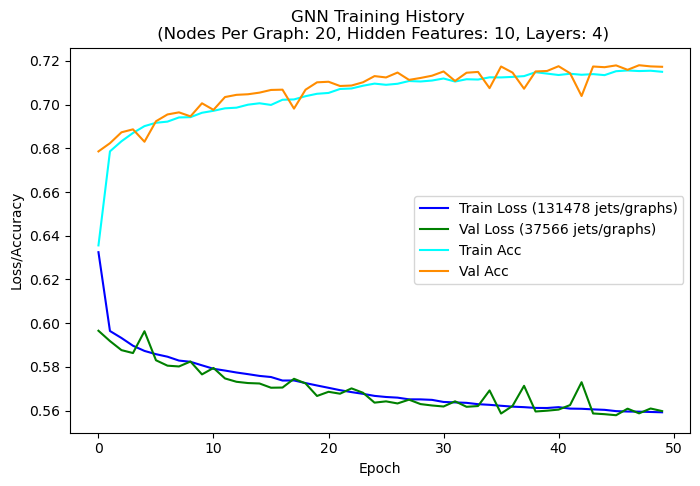

In [61]:
# Plot the training accuracy
fig = plt.figure(figsize=(8,5))
plt.plot(model_and_history['history']['train_loss'],c='b',label=f'Train Loss ({train_index} jets/graphs)')
plt.plot(model_and_history['history']['val_loss'],c='g',label=f'Val Loss ({val_index-train_index} jets/graphs)')
plt.plot(model_and_history['history']['train_accuracy'],c='cyan',label='Train Acc')
plt.plot(model_and_history['history']['val_accuracy'],c='darkorange',label='Val Acc')
plt.title(f'GNN Training History \n (Nodes Per Graph: {nodes_per_graph}, Hidden Features: {nf}, Layers: {n_layers})')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.savefig('gnn_training.png')

In [62]:
model = copy.deepcopy(model_and_history['model'])
model.eval()
with torch.no_grad():
    labels_all = None
    for i,data in enumerate(test_dataloader):
        node_size = (data.batch==0).sum()
        batch_size = data.x.shape[0]
        node_size, n_nodes = data[0].x.size()

#         data = [d.to(device) for d in data]
#         data = [d.view(-1, d.size(2)) for d in data]
#         node_loc  = torch.stack([ data.x[:,1],data.x[:,2] ], dim=1).reshape(data.x.shape[0],2).to(device)
        edge_index = data.edge_index.to(device)
        edge_attr = data.edge_attr.to(device)
        labels = data.y.double().reshape(batch_size//node_size,).cpu()


#         edges = loader.dataset.get_edges(batch_size, n_nodes)
        edges = [edge_index[0,:].to(device), edge_index[1,:].to(device)]
#         print('hello:',edges[0])

        optimizer.zero_grad()

        node_features = torch.stack([data.x[:,1], 
                                     data.x[:,2],
                                     data.x[:,0], 
                                     data.x[:,3], 
                                     data.x[:,4],
                                     data.x[:,5], 
                                     data.x[:,6],
                                     data.x[:,7] ], dim=1).to(device)
        
        labels_pred = model(node_features, edges, edge_attr).cpu()
        
        if labels_all is not None:
            labels_all = torch.cat([labels_all,labels],dim=0)
            labels_pred_all = torch.cat([labels_pred_all,labels_pred],dim=0)
        else:
            labels_all = copy.deepcopy(labels)
            labels_pred_all = copy.deepcopy(labels_pred)

In [63]:
# labels_all

In [64]:
# labels_pred_all

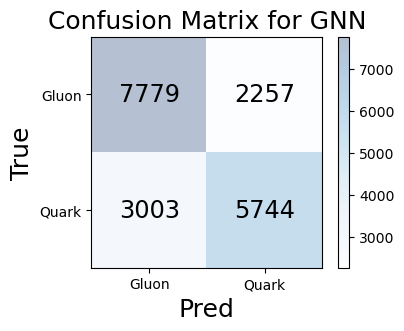

Accuracy for GNN:  tensor(0.7200)


In [65]:
from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=labels_all, y_pred=labels_pred_all.argmax(dim=1))
# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(4, 3))
im = ax.imshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Pred', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.title('Confusion Matrix for GNN', fontsize=18)
plt.xticks(ticks=[0,1],labels=['Gluon','Quark'])
plt.yticks(ticks=[0,1],labels=['Gluon','Quark'])
plt.colorbar(im)
plt.show()

size=labels_all.shape[0]
num_correct = (labels_all==labels_pred_all.argmax(dim=1)).sum().int()
print('Accuracy for GNN: ',num_correct/size)

## Equivariant GNN

In [66]:
class EGCL(nn.Module):
    """Graph Neural Net with global state and fixed number of nodes per graph.
    Args:
          hidden_dim: Number of hidden units.
          num_nodes: Maximum number of nodes (for self-attentive pooling).
          global_agg: Global aggregation function ('attn' or 'sum').
          temp: Softmax temperature.
    """

    def __init__(self, input_nf, output_nf, hidden_nf, edges_in_d=0, nodes_att_dim=0, act_fn=nn.ReLU(), recurrent=True, coords_weight=1.0, attention=False, clamp=False, norm_diff=False, tanh=False):
        super(EGCL, self).__init__()
        input_edge = input_nf * 2 # hi + hj dim = num_features*2
        self.coords_weight = coords_weight
        self.recurrent = recurrent
        self.attention = attention
        self.norm_diff = norm_diff
        self.tanh = tanh
        edge_coords_nf = 1 # |xi-xj| dim =1


        self.edge_mlp = nn.Sequential( nn.Linear(input_edge + edge_coords_nf + edges_in_d, hidden_nf),
                                      act_fn,
                                      nn.Linear(hidden_nf, hidden_nf),
                                      act_fn,
                                      nn.Linear(hidden_nf, hidden_nf),
                                      act_fn)

        self.node_mlp = nn.Sequential( nn.Linear(hidden_nf + input_nf + nodes_att_dim, hidden_nf),
                                       act_fn,
                                       nn.Linear(hidden_nf, output_nf),
                                       act_fn,
                                       nn.Linear(hidden_nf, output_nf))

        layer = nn.Linear(hidden_nf, 1, bias=False)
        torch.nn.init.xavier_uniform_(layer.weight, gain=0.001)

        self.clamp = clamp
        coord_mlp = []
        coord_mlp.append(nn.Linear(hidden_nf, hidden_nf))
        coord_mlp.append(act_fn)
        coord_mlp.append(layer)
        if self.tanh:
            coord_mlp.append(nn.Tanh())
            self.coords_range = nn.Parameter(torch.ones(1))*3
        self.coord_mlp = nn.Sequential(*coord_mlp)

        if self.attention:
            self.att_mlp = nn.Sequential(
                nn.Linear(hidden_nf, 1),
                nn.Sigmoid())

        #if recurrent:
        #    self.gru = nn.GRUCell(hidden_nf, hidden_nf)


    def edge_model(self, source, target, radial, edge_attr):
        if edge_attr is None:  # Unused.
            out = torch.cat([source, target, radial], dim=1) #hi,hj, |x_i-x_j|
        else:
            out = torch.cat([source, target, radial, edge_attr], dim=1) #hi,hj, |x_i-x_j|, a_ij
        m_ij = self.edge_mlp(out)
        if self.attention:
            att_val = self.att_mlp(m_ij)
            m_ij = m_ij * att_val
        return m_ij

    def node_model(self, h, edge_index, edge_attr, node_attr):
        row, col = edge_index
#         agg = unsorted_segment_sum(edge_attr, row, num_segments=x.size(0))
        size = int(edge_attr.shape[0]/h.shape[0])
        aggregate = nn.AvgPool1d(kernel_size=size, stride=size)
        if node_attr is not None:
            agg = torch.cat([h, aggregate(edge_attr.T).T, node_attr], dim=1)
        else:
            agg = torch.cat([h, aggregate(edge_attr.T).T], dim=1)  # h_i, m_i
        hi_lplus1 = self.node_mlp(agg)
        if self.recurrent:
            hi_lplus1 = h + hi_lplus1
        return hi_lplus1, agg

    def coord_model(self, coord, edge_index, coord_diff, m_ij):
        row, col = edge_index
        weighted_connection_vector = coord_diff * self.coord_mlp(m_ij)
        weighted_connection_vector = torch.clamp(weighted_connection_vector, min=-100, max=100) #This is never activated but just in case it case it explosed it may save the train
#         agg = unsorted_segment_mean(trans, row, num_segments=coord.size(0))
        size = int(m_ij.shape[0]/coord.shape[0])
        aggregate = nn.AvgPool1d(kernel_size=size, stride=size)
        coord += aggregate(weighted_connection_vector.T).T*self.coords_weight
        return coord

    def coord2radial(self, edge_index, coordinates):
        row, col = edge_index
        coord_direction = coordinates[row] - coordinates[col]
        radial = torch.sum((coord_direction)**2, dim = 1).unsqueeze(1)

        if self.norm_diff:
            norm = torch.sqrt(radial) + 1
            coord_direction = coord_direction/norm

        return radial, coord_direction
    
    def equi_coordinate(self, edge_index, coordinates):
        row, col = edge_index
        equi_coordinates = coordinates[row] - (coordinates[row] - coordinates[col])/np.log(row.shape[0])#torch.sum((coordinates[row] - coordinates[col])**2,dim=1).sqrt().reshape(row.shape[0],1)
        size = int(len(row)/coordinates.shape[0])
        aggregate = nn.AvgPool1d(kernel_size=size, stride=size)
        return aggregate(equi_coordinates.T).T

    def forward(self, h, edge_index, coordinates, edge_attr=None, node_attr=None):
        row, col = edge_index
        radial, coord_direction = self.coord2radial(edge_index, coordinates)  # returns radial distance and direction between points
        m_ij = self.edge_model(h[row], h[col], radial, edge_attr)
        coordinates = self.equi_coordinate(edge_index, coordinates)
        coordinates = self.coord_model(coordinates, edge_index, coord_direction, m_ij)
        h, agg = self.node_model(h, edge_index, m_ij, node_attr)
        # coord = self.node_coord_model(h, coord)
        # x = self.node_model(x, edge_index, x[col], u, batch)  # GCN
        return h, coordinates, edge_attr

In [67]:
class EGNN(nn.Module):
    def __init__(self, in_node_nf, in_edge_nf, hidden_nf, device='cpu', act_fn=nn.LeakyReLU(0.2), n_layers=4, kernel_size = None, coords_weight=1.0):
        super(EGNN, self).__init__()
        self.hidden_nf = hidden_nf
        self.device = device
        self.n_layers = n_layers
        #self.reg = reg
        ### Encoder
        #self.add_module("gcl_0", EGCL(in_node_nf, self.hidden_nf, self.hidden_nf, edges_in_d=in_edge_nf, act_fn=act_fn, recurrent=False, coords_weight=coords_weight))
        self.embedding = nn.Linear(in_node_nf, self.hidden_nf)
        for i in range(0, n_layers):
            self.add_module("gcl_%d" % i, EGCL(self.hidden_nf, 
                                               self.hidden_nf, 
                                               self.hidden_nf, 
                                               edges_in_d=in_edge_nf, 
                                               act_fn=act_fn, 
                                               recurrent=True, 
                                               coords_weight=coords_weight))
        
        self.mean_pool = nn.AvgPool1d(kernel_size=kernel_size, stride=kernel_size)
        self.coord_dim = 2
        self.decoder = nn.Sequential( nn.Linear(self.coord_dim, self.coord_dim**2),
                                      act_fn,
                                      nn.Linear(self.coord_dim**2, self.coord_dim),
                                      act_fn,
                                      nn.Linear(self.coord_dim, 2) )
        self.to(self.device)
        

    def forward(self, h, x, edge_index, edge_attr):#, vel=None):
        h = self.embedding(h)
        for i in range(0, self.n_layers):
            #if vel is not None:
                #vel_attr = get_velocity_attr(x, vel, edges[0], edges[1])
                #edge_attr = torch.cat([edge_attr0, vel_attr], dim=1).detach()
            h, x, _ = self._modules["gcl_%d" % i](h, edge_index, x, edge_attr=edge_attr)

        x = self.mean_pool(x.T).T
        x = self.decoder(x)
#         x = F.elu(x)
        return F.log_softmax(x, dim=1)

In [68]:
torch.manual_seed(3)
nf = 10
n_layers = 4
kernel_size =x_data_proc.shape[1]
in_node_nf= x_data_proc.shape[2]
model_key = 'EGNN'
model = EGNN(in_node_nf=in_node_nf, 
             in_edge_nf=2,
             hidden_nf=nf, #args.nf, 
             n_layers=n_layers, #args.n_layers, 
             kernel_size = kernel_size,
             device=device)
lr = 1e-3
wd = 1e-12
optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=wd) #args.lr, weight_decay=args.weight_decay)
# loss_mse = nn.MSELoss()
loss_fn = torch.nn.CrossEntropyLoss()

In [69]:
epochs = 100

model_and_history = training(model = model,
                             epochs = epochs, 
                             loader_train = train_dataloader, 
                             loader_val  = val_dataloader, 
                             loader_test = test_dataloader)

Epoch: 0 |  Best Train Loss: 0.63428276 | Best Val Loss: 0.61133711 | Best Train Acc: 0.63660841 | Best Val Acc: 0.66709258
Epoch: 1 |  Best Train Loss: 0.60658159 | Best Val Loss: 0.60041246 | Best Train Acc: 0.67294148 | Best Val Acc: 0.67686206
Epoch: 2 |  Best Train Loss: 0.60102028 | Best Val Loss: 0.59549269 | Best Train Acc: 0.67809063 | Best Val Acc: 0.68021615
Epoch: 3 |  Best Train Loss: 0.60102028 | Best Val Loss: 0.59549269 | Best Train Acc: 0.67809063 | Best Val Acc: 0.68021615
Epoch: 4 |  Best Train Loss: 0.59758417 | Best Val Loss: 0.59258048 | Best Train Acc: 0.68073746 | Best Val Acc: 0.68554012
Epoch: 5 |  Best Train Loss: 0.59758417 | Best Val Loss: 0.59258048 | Best Train Acc: 0.68073746 | Best Val Acc: 0.68554012
Epoch: 6 |  Best Train Loss: 0.59758417 | Best Val Loss: 0.59258048 | Best Train Acc: 0.68073746 | Best Val Acc: 0.68554012
Epoch: 7 |  Best Train Loss: 0.59546261 | Best Val Loss: 0.59207129 | Best Train Acc: 0.68325499 | Best Val Acc: 0.68394293
Epoch: 8

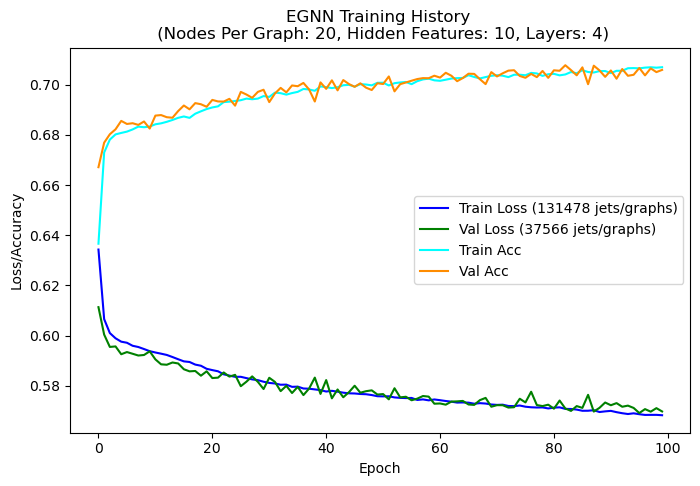

In [70]:
# Plot the training accuracy
fig = plt.figure(figsize=(8,5))
plt.plot(model_and_history['history']['train_loss'],c='b',label=f'Train Loss ({train_index} jets/graphs)')
plt.plot(model_and_history['history']['val_loss'],c='g',label=f'Val Loss ({val_index-train_index} jets/graphs)')
plt.plot(model_and_history['history']['train_accuracy'],c='cyan',label='Train Acc')
plt.plot(model_and_history['history']['val_accuracy'],c='darkorange',label='Val Acc')
plt.title(f'EGNN Training History \n (Nodes Per Graph: {nodes_per_graph}, Hidden Features: {nf}, Layers: {n_layers})')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.savefig('egnn_training.png')

In [71]:
model = copy.deepcopy(model_and_history['model'])
model.eval()
with torch.no_grad():
    labels_all = None
    for i,data in enumerate(test_dataloader):
        node_size = (data.batch==0).sum()
        batch_size = data.x.shape[0]
        node_size, n_nodes = data[0].x.size()

#         data = [d.to(device) for d in data]
#         data = [d.view(-1, d.size(2)) for d in data]
#         node_loc  = torch.stack([ data.x[:,1],data.x[:,2] ], dim=1).reshape(data.x.shape[0],2).to(device)
        edge_index = data.edge_index.to(device)
        edge_attr = data.edge_attr.to(device)
        labels = data.y.double().reshape(batch_size//node_size,).cpu()


#         edges = loader.dataset.get_edges(batch_size, n_nodes)
        edge_inds = [edge_index[0,:].to(device), edge_index[1,:].to(device)]
#         print('hello:',edges[0])

        optimizer.zero_grad()

        locations = torch.stack([data.x[:,1], 
                                 data.x[:,2]  ], dim=1).to(device)
        
        node_features = torch.stack([data.x[:,1], 
                                     data.x[:,2],
                                     data.x[:,0], 
                                     data.x[:,3], 
                                     data.x[:,4],
                                     data.x[:,5], 
                                     data.x[:,6],
                                     data.x[:,7] ], dim=1).to(device)
        

#             nodes = torch.ones(node_features.size(0), 1).to(device)  # all input nodes are set to 1
        rows, cols = edge_inds
        locations_dist = torch.sum( (locations[rows] - locations[cols])**2, dim=1).unsqueeze(1)  # relative distances among locations 
#             vel_attr = get_velocity_attr(loc, vel, rows, cols).detach()
        edge_attr = torch.cat([ edge_attr, locations_dist ], dim=1).detach()  # concatenate all edge properties
        labels_pred = model(node_features, locations, edge_inds, edge_attr).cpu()
        
        if labels_all is not None:
            labels_all = torch.cat([labels_all,labels],dim=0)
            labels_pred_all = torch.cat([labels_pred_all,labels_pred],dim=0)
        else:
            labels_all = copy.deepcopy(labels)
            labels_pred_all = copy.deepcopy(labels_pred)

In [72]:
# labels_all

In [73]:
# labels_pred_all

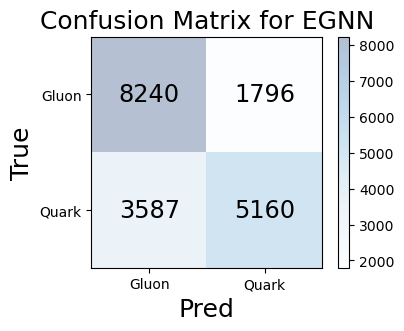

Accuracy for EGNN:  tensor(0.7134)


In [74]:
from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=labels_all, y_pred=labels_pred_all.argmax(dim=1))
# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(4, 3))
im = ax.imshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Pred', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.title('Confusion Matrix for EGNN', fontsize=18)
plt.xticks(ticks=[0,1],labels=['Gluon','Quark'])
plt.yticks(ticks=[0,1],labels=['Gluon','Quark'])
plt.colorbar(im)
plt.show()

size=labels_all.shape[0]
num_correct = (labels_all==labels_pred_all.argmax(dim=1)).sum().int()
print('Accuracy for EGNN: ',num_correct/size)

## Moving Forward

- Run on GPU(s)
- Increase sample size
- Modify edge and node MLPs in GNNs, change hyperparamters
- Track run times
- Build quantum versions of GNN/EGNN using Verdon et al. 2019 (Graph Isomorphism)
- Manipulate equivariance. Compare to implementation of 2021 GSOC ENN for Clasification of Dark Matter Substructure
- Change preprocessing
- Try another jet dataset